### Instagis - Data Science Technical test 
Version 1.1.4

# Assignment  3: Topic Modeling

## My Aprouch to the problem

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from itertools import chain
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer        
from nltk.stem import WordNetLemmatizer 
import spacy
import string
import emoji
from time import time
from collections import Counter
# Library's to plot
import seaborn as sbs
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from sklearn.preprocessing import binarize,MinMaxScaler,RobustScaler,normalize,MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# Init the spacy object call parser
parser = spacy.load("en")

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [3]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # delete links
    text = re.sub(pattern=r'https?:\/\/.*[\r\n]*',repl='URL', string=text, flags=re.MULTILINE | re.IGNORECASE)
    
    # get rid of newlines
    text = text.strip().replace("\n+|\n\n+|\r"," ")
    
    #get rid of the accent marks
    text=text.replace(u"\uFFFD",'')
    
    # Join the negation forms
    negation_finder=re.compile(r"""n't""",re.IGNORECASE)
    text=negation_finder.sub('nt',text)
    
    #Replace the newlines that are attached to a word with only the word
    newlines_finder=re.compile("\n\w+|\n\n\w+", re.IGNORECASE)
    w=newlines_finder.findall(text)
    for t in w:
        if len(t.split('\n\n'))>1:
            text=re.sub(t,t.split('\n\n')[1],text)
        else:
            text=re.sub(t,"",text)
    
    #get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
    text=re.sub(r'\''," ",text)
    
    # replace twitter the symbol of the user names
    hashtag_finder = re.compile(r"(?:\@)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace hashtags
    hashtag_finder = re.compile(r"(?:\#)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace numbers
    number_finder =re.compile(r"\s?[0-9]+\.?[0-9]*")
    text = number_finder.sub(" NUMBER ", text)
    
    # Replace phone numbers
    phone_number_finder=re.compile(r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )""", re.IGNORECASE)
    text = phone_number_finder.sub(" ", text)
    
    # replace HTML symbols
    html_finder = re.compile(r'<.*?>')
    text=html_finder.sub('', text)
    
    # delete especial characters and some HTML symbols
    for remove in map(lambda r: re.compile(re.escape(r)),["\"", "=", "&", "%", "$", "%", "^", "*","(", ")", 
                       "{", "}","[", "]", "|", "/", "\\",">","<","-", "'",
                       "--", "---","&gt;","&lt;","-----", "---", "...", "“", "”", "'ve"]):
        text=remove.sub("",text)
    
    #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')

    return text

In [4]:
# A custom function to clean the text before sending it into the vectorizer
def hardCleanText(text):
    
    # get rid of newlines
    text = text.strip().replace("\n+|\n\n+|\r"," ")
    
    #Replace the newlines that are attached to a word with only the word
    newlines_finder=re.compile("\n\w+|\n\n\w+", re.IGNORECASE)
    w=newlines_finder.findall(text)
    for t in w:
        if len(t.split('\n\n'))>1:
            text=re.sub(t,t.split('\n\n')[1],text)
        else:
            text=re.sub(t,"",text)
    
    #get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
    text=re.sub(r'\''," ",text)
    
      # replace twitter the symbol of the user names
    hashtag_finder = re.compile(r"(?:\@)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace hashtags
    hashtag_finder = re.compile(r"(?:\#)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
      # replace numbers
    number_finder =re.compile(r"\s?[0-9]+\.?[0-9]*")
    text = number_finder.sub(" NUMBER ", text)
    
    # Replace phone numbers
    phone_number_finder=re.compile(r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )""", re.IGNORECASE)
    text = phone_number_finder.sub(" ", text)
    
    # replace HTML symbols
    text=text.replace("&amp;", "and")
    
    # delete especial characters and some HTML symbols
    for remove in map(lambda r: re.compile(re.escape(r)),[",", ":", "\"", "=", "&", ";", "%", "$", "%", "^", "*","(", ")", 
                       "{", "}","[", "]", "|", "/", "\\",">","<","-","!","?", ".", "'",
                       "--", "---","&gt;","&lt;","-----", "---", "...", "“", "”", "'ve"]):
        text=remove.sub(" ",text)
    
    #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')

    return text

In [5]:
def tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=True,min_words=2,only_alpha=True,digit=True):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
    
    if(stem & lemma):
        stem = SnowballStemmer('english')
        tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
        tokens = [stem.stem(token).lower() for token in tokens if token not in string.punctuation]
    elif(lemma):
        tokens = [token.lemma_.lower() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [stem.stem(token.lower_) for token in tokens if not (token.is_punct)]
    
    return tokens

In [6]:
def spacy_tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=True,min_words=2,only_alpha=False,digit=False):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
        
    tokens=[(token,token.pos_) for token in tokens]
    
    if(lemma & stem):
        stem = SnowballStemmer('english')
        tokens = [(token[0].lemma_,token[1]) if token[0].lemma_ != "-PRON-" 
                  else (token[0].lower_,token[1]) for token in tokens]
        tokens = [(stem.stem(token[0]).lower(),token[1]) for token in tokens 
                  if token[0] not in string.punctuation]
    elif(lemma):
        tokens = [(token[0].lemma_.lower(),token[1]) if token[0].lemma_ != "-PRON-" 
                  else (token[0].lower_,token[1]) for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [(stem.stem(token[0].lower_),token[1]) for token in tokens if not (token[0].is_punct)]

    tokens=[(token[0]+"_"+token[1]) for token in tokens]
    #tokens=[item for item in chain(tokens,ents)] 

    return tokens

In [7]:
def negation_3_words_rules(text,clp_finder,negation_finder,stop_words=True):
    # Create a list with the tokenize words of the text
    words=word_tokenize(text)
    #Delete stop words
    if(stop_words):
        word_list = []
        for w in words:
            if w not in stopWords:
                word_list.append(w)
    # Create the list with the word negation list
    neg_list=negation_finder.findall(text)
    # Create the list with the clause level punctuation list
    clp_list=clp_finder.findall(text)
    # Create the index list where we are going to insert the index of the words which will be replace
    ind=[]
    # Create the index list with the 3 words rules
    for s in neg_list:
        i=0
        for w in word_list:
            if(s==w):
                ind.append(i)
                if(i+3<len(word_list)):
                    ind.append(i+1)
                    ind.append(i+2)
                    ind.append(i+3)
                elif(i+2<len(word_list)):
                    ind.append(i+1)
                    ind.append(i+2)
                elif(i+1<len(word_list)):
                    ind.append(i+1)
            i+=1
   
    neg_list=[word_list[i]+'_NEG' for i in ind]
    for i in range(0,len(ind)):
        word_list[ind[i]]=neg_list[i]
    word_list
    aux=""
    for e in word_list:
        aux=aux+e+" "
    text=aux
    # delete especial characters
    #esp_character_finder=re.compile(r""""\n,|\n:|\n!|\n!!|\n?|\n.|\n;""",flags=re.IGNORECASE)
    #text=esp_character_finder.sub("",text)
    
    #Delete everything is not
    text=re.sub(r'[^a-zA-Z \_\n+]+','',text)
    
     #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')
    
    return text

In [8]:
def negation_marks(text,clp_finder,negation_finder,stop_words=True):
    
    # 1.-Create the list with the negation words and punctations, also a list with their indexs
    # Create a list with the tokenize words of the text
    words=word_tokenize(text)
    #Delete stop words
    if(stop_words):
        word_list = []
        for w in words:
            if w not in stopWords:
                word_list.append(w)
    # Create the list with the word negation list
    neg_list=negation_finder.findall(text)
    # Create the list with the clause level punctuation list
    clp_list=clp_finder.findall(text)
    # Create the list with the indexs of the clause level punctuation list
    clp_list_ind=[]
    j=0
    for clp in clp_list:
        i=0
        for w in word_list:
            if(clp==w):
                if(i>j):
                    clp_list_ind.append(i)
                    j=i
                    break

            i+=1
    # 2.-Create the list with the indexs of the negation list    
    neg_list_ind=[]
    j=0
    for neg in neg_list:
        i=0
        for w in word_list:
            if(neg==w):
                if(i>=j):
                    neg_list_ind.append(i)
                    j=i
                    break
            i+=1
            
    # 3.-Create the intervals for the negation marks
    intervals=[]
    aux=0
    ind=0
    for i in neg_list_ind:
        for j in clp_list_ind:
            if(i<j):
                if(i>=aux):
                    intervals.append([i,j])
                    aux=j
                    break
    
    # 4.-Add the negation marks to the document
    negation_marks=[word_list[j]+'_NEG' for i in intervals for j in range(i[0],i[1])]
    n=0
    for i in intervals:
        for j in range(i[0],i[1]):
            word_list[j]=negation_marks[n]
            n+=1
    aux=""
    for e in word_list:
        aux=aux+e+" "
    text=aux
    # delete especial characters
    #esp_character_finder=re.compile(r""""\n,|\n:|\n!|\n!!|\n?|\n.|\n;""",flags=re.IGNORECASE)
    #text=esp_character_finder.sub("",text)
    
    #Delete everything is not
    text=re.sub(r'[^a-zA-Z \_\n+]+','',text)
    
     #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')
    
    return text

In [9]:
df = pd.read_csv('train-data-1513704817538.csv')
print(df.shape)
df.head()

(12627, 2)


,case,message
0,NEGATIVE,She/he was elected because???
1,NEGATIVE,That a elective surgery. So NO
2,POSITIVE,Danica roem is a mentally ill freak. this sick...
3,NEGATIVE,I would gladly paid for psiquiatric treatment....
4,NEGATIVE,NO! You must pay for it yourself. You were n...


## Pre-processing

#### Create the clean message

In [10]:
df.loc[:,"clean_message"]=df.loc[:,"message"].apply(lambda x: cleanText(x)).copy()

In [11]:
negation_finder=re.compile(r"""(never|nothing|nowhere|noone|none|not|no|havent|hasnt|hadnt|cant|couldnt|shouldnt|
wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)""",flags=re.I | re.X | re.MULTILINE )
clp_finder=re.compile(r"""[,.:;!?]""",flags=re.I | re.X | re.MULTILINE )

In [12]:
df.loc[:,"clean_message_neg"]=df.loc[:,"clean_message"].apply(
    lambda x: negation_marks(x,clp_finder,negation_finder) if (clp_finder.findall(x)==[]) 
    else negation_3_words_rules(x,clp_finder,negation_finder)).copy()

In [13]:
df.loc[:,"clean_message"]=df.loc[:,"message"].apply(lambda x: hardCleanText(x)).copy()

#### Create the tokenize columns

In [14]:
df.loc[:,"tokenize_message"]=df.loc[:,"clean_message"].apply(lambda x: spacy_tokenizer(
    x,parser,stop_words=True)).copy()

In [15]:
df.loc[:,"neg_tokenize_message"]=df.loc[:,"clean_message_neg"].apply(lambda x: spacy_tokenizer(
    x,parser,stop_words=True)).copy()

In [16]:
#df=df.dropna(axis=0,how='any',subset=['tokenize_message']).copy()
print(df.loc[4,'clean_message'])
print(df.loc[4,'clean_message_neg'])
print(df.loc[4,'tokenize_message'])
print(df.loc[4,'neg_tokenize_message'])

NO   You must pay for it yourself   You were not born this way  it was your decision to change  now do NOT expect the American taxpayer to pick up the tab 
NO_NEG _NEG You_NEG must_NEG pay  You born way  decision change  NOT_NEG expect_NEG American_NEG taxpayer_NEG pick tab  
['must_VERB', 'pay_VERB', 'bear_VERB', 'way_NOUN', 'decision_NOUN', 'change_VERB', 'expect_VERB', 'american_ADJ', 'taxpayer_NOUN', 'pick_VERB', 'tab_NOUN']
['no_neg_ADP', 'neg_PROPN', 'you_neg_PROPN', 'must_neg_PROPN', 'pay_NOUN', 'bear_VERB', 'way_NOUN', 'decision_NOUN', 'change_NOUN', 'not_neg_PROPN', 'expect_neg_ADJ', 'american_neg_NOUN', 'taxpayer_neg_NOUN', 'pick_VERB', 'tab_NOUN']


In [17]:
text=re.sub(r'[^a-zA-Z]',' ',df.loc[11225,'clean_message'])
tokenizer(text,parser,stop_words=True,only_alpha=True,min_words=2)

['rex', 'tillerson']

#### Extract the common words with their relative weights

In [18]:
def create_common_words(max_occurrences=np.infty,min_occurrences=10,words=None):
    word_df = pd.DataFrame(
        data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurrences],
              "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurrences]},
        columns=["word", "occurrences"])
    return word_df

In [19]:
words = Counter()
for idx in df.index:
    words.update(df.loc[idx, "tokenize_message"])
words.most_common(5)

[('get_VERB', 1322),
 ('go_VERB', 1130),
 ('people_NOUN', 1072),
 ('good_ADJ', 966),
 ('trump_PROPN', 850)]

In [20]:
stop_words = stopwords.words('english')
whitelist = []
blacklist=['@number','@hashtag','@mentions']
for idx, stop_word in enumerate(stop_words):
    if stop_word not in whitelist:
        del words[stop_word]
for idx,black_word in enumerate(blacklist):
    del words[black_word]
words.most_common(5)

[('get_VERB', 1322),
 ('go_VERB', 1130),
 ('people_NOUN', 1072),
 ('good_ADJ', 966),
 ('trump_PROPN', 850)]

In [21]:
common_words=create_common_words(words=words)
common_words['weight']=common_words.occurrences/max(common_words.occurrences)
print(common_words.shape)
common_words.head(10)

(1644, 3)


,word,occurrences,weight
0,get_VERB,1322,1.000000
1,go_VERB,1130,0.854766
2,people_NOUN,1072,0.810893
3,good_ADJ,966,0.730711
4,trump_PROPN,850,0.642965
5,number_NOUN,817,0.618003
6,need_VERB,802,0.606657
7,god_PROPN,755,0.571104
8,would_VERB,744,0.562784
9,say_VERB,737,0.557489


               word  occurrences    weight
0          get_VERB         1322  1.000000
1           go_VERB         1130  0.854766
2       people_NOUN         1072  0.810893
3          good_ADJ          966  0.730711
4       trump_PROPN          850  0.642965
5       number_NOUN          817  0.618003
6         need_VERB          802  0.606657
7         god_PROPN          755  0.571104
8        would_VERB          744  0.562784
9          say_VERB          737  0.557489
10         like_ADP          667  0.504539
11        make_VERB          658  0.497731
12  president_PROPN          656  0.496218
13       think_VERB          618  0.467474
14         man_NOUN          612  0.462935
15        time_NOUN          608  0.459909
16     country_NOUN          581  0.439486
17        know_VERB          555  0.419818
18          one_NUM          515  0.389561
19       thank_VERB          502  0.379728


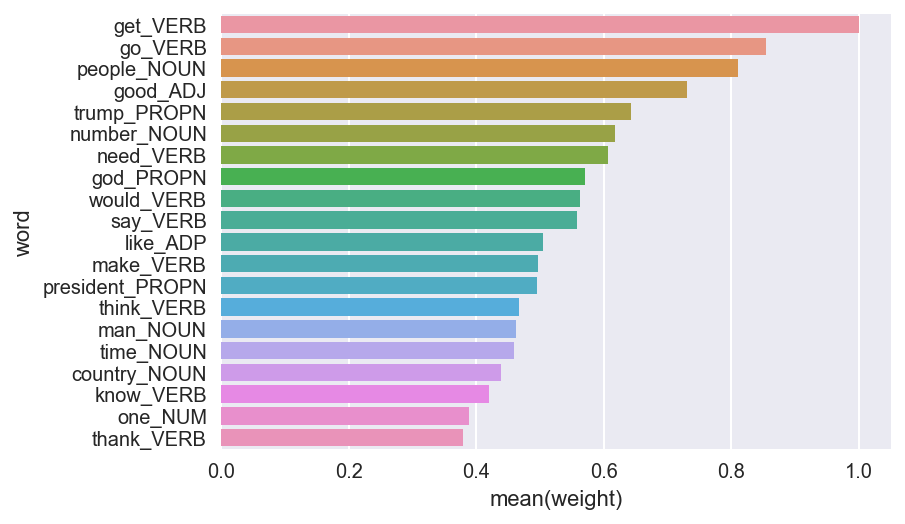

In [22]:
top_20_pos=common_words[['word','occurrences','weight']].sort_values(by='weight',ascending=False).head(20)
print(top_20_pos)
sbs.barplot(x='weight', y='word', data=top_20_pos);

In [23]:
words_dict=common_words[['word','weight']].apply(lambda x: {x['word']:x['weight']},axis=1)
words_dict=list(words_dict)
words_dict[0:3]

[{'get_VERB': 1.0},
 {'go_VERB': 0.8547655068078669},
 {'people_NOUN': 0.81089258698941}]

#### Create the  tokenize columns with words_POS

In [25]:
df.loc[:,"spacy_tokenize_message"]=df.loc[:,"clean_message"].apply(lambda x: spacy_tokenizer(
    str(x),parser,stop_words=True,only_alpha=True)).copy()
df.spacy_tokenize_message.head()

0                                         [elect_VERB]
1                         [elective_ADJ, surgery_NOUN]
2    [danica_PROPN, roem_NOUN, mentally_ADV, ill_AD...
3    [would_VERB, gladly_ADV, pay_VERB, psiquiatric...
4    [must_VERB, pay_VERB, bear_VERB, way_NOUN, dec...
Name: spacy_tokenize_message, dtype: object

In [26]:
words = Counter()
for idx in df.index:
    words.update(df.loc[idx, "spacy_tokenize_message"])
words.most_common(5)

[('get_VERB', 1322),
 ('go_VERB', 1130),
 ('people_NOUN', 1072),
 ('good_ADJ', 966),
 ('trump_PROPN', 850)]

In [27]:
common_sp_words=create_common_words(words=words)
common_sp_words['weight']=common_sp_words.occurrences/max(common_sp_words.occurrences)
print(common_sp_words.shape)
common_sp_words.head(10)

(1638, 3)


,word,occurrences,weight
0,get_VERB,1322,1.000000
1,go_VERB,1130,0.854766
2,people_NOUN,1072,0.810893
3,good_ADJ,966,0.730711
4,trump_PROPN,850,0.642965
5,number_NOUN,817,0.618003
6,need_VERB,802,0.606657
7,god_PROPN,755,0.571104
8,say_VERB,737,0.557489
9,would_VERB,732,0.553707


               word  occurrences    weight
0          get_VERB         1322  1.000000
1           go_VERB         1130  0.854766
2       people_NOUN         1072  0.810893
3          good_ADJ          966  0.730711
4       trump_PROPN          850  0.642965
5       number_NOUN          817  0.618003
6         need_VERB          802  0.606657
7         god_PROPN          755  0.571104
8          say_VERB          737  0.557489
9        would_VERB          732  0.553707
10         like_ADP          667  0.504539
11        make_VERB          658  0.497731
12  president_PROPN          656  0.496218
13       think_VERB          618  0.467474
14         man_NOUN          612  0.462935
15        time_NOUN          608  0.459909
16     country_NOUN          581  0.439486
17        know_VERB          555  0.419818
18          one_NUM          515  0.389561
19       thank_VERB          502  0.379728


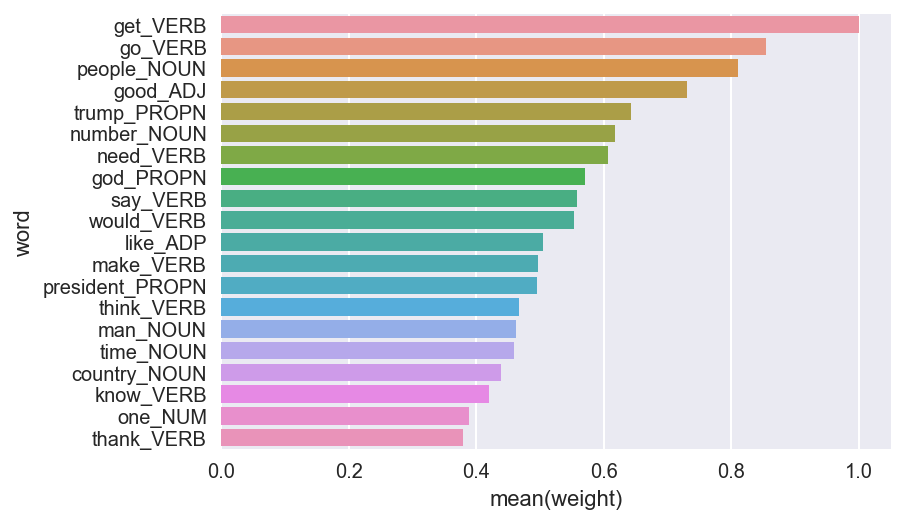

In [28]:
top_20_sp_pos=common_sp_words[['word','occurrences','weight']].sort_values(by='weight',ascending=False).head(20)
print(top_20_sp_pos)
sbs.barplot(x='weight', y='word', data=top_20_sp_pos);

In [29]:
words_sp_pos_dict=common_sp_words[['word','weight']].apply(lambda x:{'word': x['word'],'weight':x['weight']},axis=1)
words_sp_pos_dict=list(words_sp_pos_dict)
aux = {}
for item in words_sp_pos_dict:
   word = item.pop('word')
   aux[word] = item
words_sp_pos_dict=aux
words_sp_pos_dict
words_sp_pos_dict.get('god_PROPN').get('weight')

0.5711043872919819

### Create the vectors to train the model

In [31]:
# Print the head of df
X=df.iloc[:,range(1,df.shape[1])]
# Create training and test sets
#X_train, X_test = train_test_split(X,random_state=0,test_size=0.3)

In [35]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer_spacy = CountVectorizer(
    tokenizer=spacy_tokenizer,stop_words='english',lowercase=True,min_df=10,ngram_range=(1,2))

# Transform the training data using only the 'text' column values: count_train 
dtm_count_spacy = count_vectorizer_spacy.fit_transform(X.clean_message_neg)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer_spacy.get_feature_names()[0:30])

['a_neg_NOUN', 'abide_VERB', 'ability_NOUN', 'able_ADJ', 'abortion_NOUN', 'absolute_ADJ', 'absolutely_ADV', 'abuse_VERB', 'accept_VERB', 'accomplish_VERB', 'accountable_ADJ', 'accusation_NOUN', 'accuse_VERB', 'across_ADP', 'act_NOUN', 'act_VERB', 'act_VERB like_ADP', 'action_NOUN', 'actor_NOUN', 'actually_ADV', 'add_VERB', 'administration_NOUN', 'admire_VERB', 'admit_VERB', 'adult_NOUN', 'afraid_ADJ', 'age_NOUN', 'agenda_NOUN', 'agent_NOUN', 'ago_ADV']


## Visualize the Clusters

#### Exploring the clusters

* After we create the topis Using the LDA algorithm, we are going to visualize it using the pyLDAvis library, which extracts information from a topic model and creates a web-based visualization where users can interactively explore the model 

* To understand what's going on we are going to label our data using LDA model with the number of the topic which has the best probability to match with the sentence. To do that we have created a function which will be apllied to the "clean_message" column row by row

* Also, we would like to do the same for the nmf cluster, so we are going to display the full text of the main docs for each topic, so we are going to create the display_topic() function

**References: **

*<https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/>*

*<https://nlpforhackers.io/topic-modeling/>*

*<https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730>*

*<https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d>*

*<https://github.com/bmabey/pyLDAvis>*

In [40]:
def get_cluster(model,vectorizer,text):
    x = model.transform(vectorizer.transform([text]))[0]
    for i in range(0,9):
        if(x[i]==x.max()):
            return(i)
        
def get_cluster_prob(model,vectorizer,text):
    x = model.transform(vectorizer.transform([text]))[0]
    return(x.max())

In [41]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [42]:
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar

def get_similars(X,text,model,vectorizer):
    x = nmf_model.transform(count_vectorizer.transform([text]))[0]
    similarities = most_similar(x, model)
    document_id, similarity = similarities[1]
    print(X[document_id])
    document_id, similarity = similarities[2]
    print(X[document_id])
    document_id, similarity = similarities[3]
    print(X[document_id])
    document_id, similarity = similarities[4]
    print(X[document_id])

In [49]:
no_topics =4

In [54]:
# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=50, learning_method='online', 
                                      learning_offset=50.,random_state=0).fit(dtm_count_spacy)
lda   = lda_model.fit(dtm_count_spacy)
lda_W = lda_model.transform(dtm_count_spacy)
lda_H = lda_model.components_

In [55]:
df['count_spacy_cluster']=df.clean_message.apply(lambda x: get_cluster(model=lda_model,vectorizer=count_vectorizer_spacy,text=x))
df['count_spacy_cluster_prob']=df.clean_message.apply(lambda x: get_cluster_prob(model=lda_model,vectorizer=count_vectorizer_spacy,text=x))

In [56]:
pyLDAvis.sklearn.prepare(lda_model, dtm_count_spacy, count_vectorizer_spacy, mds='PCoA')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      34.740107        1       1  0.065025 -0.052615
1      25.598907        1       2 -0.161301 -0.263287
2      21.779895        1       3  0.299262  0.049928
0      17.881091        1       4 -0.202985  0.265974, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
1230  Default  1083.000000        neg_NOUN  1083.000000  30.0000  30.0000
1446  Default   877.000000  president_NOUN   877.000000  29.0000  29.0000
1287  Default  1066.000000     number_NOUN  1066.000000  28.0000  28.0000
757   Default   932.000000        good_ADJ   932.000000  27.0000  27.0000
1106  Default   589.000000        man_NOUN   589.000000  26.0000  26.0000
2030  Default   675.000000      would_VERB   675.000000  25.0000  25.0000
1600  Default   661.000000        say_VERB   661.000000  24.0000  24.0000
705   Default  1166.000000        get_VERB  1166.000000  23.0000  23.0000
1830  Default   479.000000      thank_VERB   479.000000  22.0000  22.0000
751   Default   434.000000        god_NOUN   434.000000  21.0000  21.0000
1897  Default   647.000000      trump_NOUN   647.000000  20.0000  20.0000
1863  Default   585.000000       time_NOUN   585.000000  19.0000  19.0000
190   Default   397.000000      bless_VERB   397.000000  18.0000  18.0000
503   Default   354.000000   dont_neg_VERB   354.000000  17.0000  17.0000
1303  Default   309.000000      obama_NOUN   309.000000  16.0000  16.0000
2052  Default   284.000000        yes_INTJ   284.000000  15.0000  15.0000
777   Default   470.000000       great_ADJ   470.000000  14.0000  14.0000
995   Default   268.000000        law_NOUN   268.000000  13.0000  13.0000
749   Default   297.000000        god_INTJ   297.000000  12.0000  12.0000
954   Default   296.000000       keep_VERB   296.000000  11.0000  11.0000
736   Default  1048.000000         go_VERB  1048.000000  10.0000  10.0000
2048  Default   374.000000       year_NOUN   374.000000   9.0000   9.0000
1077  Default   275.000000       love_VERB   275.000000   8.0000   8.0000
1845  Default   530.000000      think_VERB   530.000000   7.0000   7.0000
340   Default   345.000000       come_VERB   345.000000   6.0000   6.0000
1246  Default   232.000000       news_NOUN   232.000000   5.0000   5.0000
211   Default   204.000000        boy_NOUN   204.000000   4.0000   4.0000
1092  Default   604.000000       make_VERB   604.000000   3.0000   3.0000
1753  Default   227.000000       still_ADV   227.000000   2.0000   2.0000
60    Default   251.000000    american_ADJ   251.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
982    Topic4   122.676623       lady_NOUN   123.440477   1.7152  -4.9639
928    Topic4   119.000400       jail_NOUN   119.764019   1.7150  -4.9943
867    Topic4   106.855845      house_NOUN   107.624908   1.7143  -5.1020
308    Topic4   102.748958    citizen_NOUN   103.507169   1.7141  -5.1412
820    Topic4    95.617145       head_NOUN    96.390843   1.7134  -5.2131
1609   Topic4    83.631142      scouts_ADV    84.367282   1.7127  -5.3470
6      Topic4    85.204339  absolutely_ADV    85.959689   1.7126  -5.3284
1441   Topic4    85.444174     prayer_NOUN    86.202667   1.7126  -5.3256
640    Topic4    82.318578     finally_ADV    83.092131   1.7121  -5.3629
860    Topic4    81.838557       hope_NOUN    82.607773   1.7121  -5.3687
310    Topic4    78.250606       city_NOUN    79.010013   1.7118  -5.4135
1005   Topic4    78.402225      learn_VERB    79.168170   1.7117  -5.4116
224    Topic4    74.260981      break_VERB    75.015239   1.7113  -5.4659
284    Topic4    76.617647     change_NOUN    77.396062   1.7113  -5.4346
1249   Topic4    75.592472        next_ADJ    76.369889   1.7112  -5.4481
617    Topic4    74.219761     father_NOUN    74.985431   1.7112  -5.4664
1212   

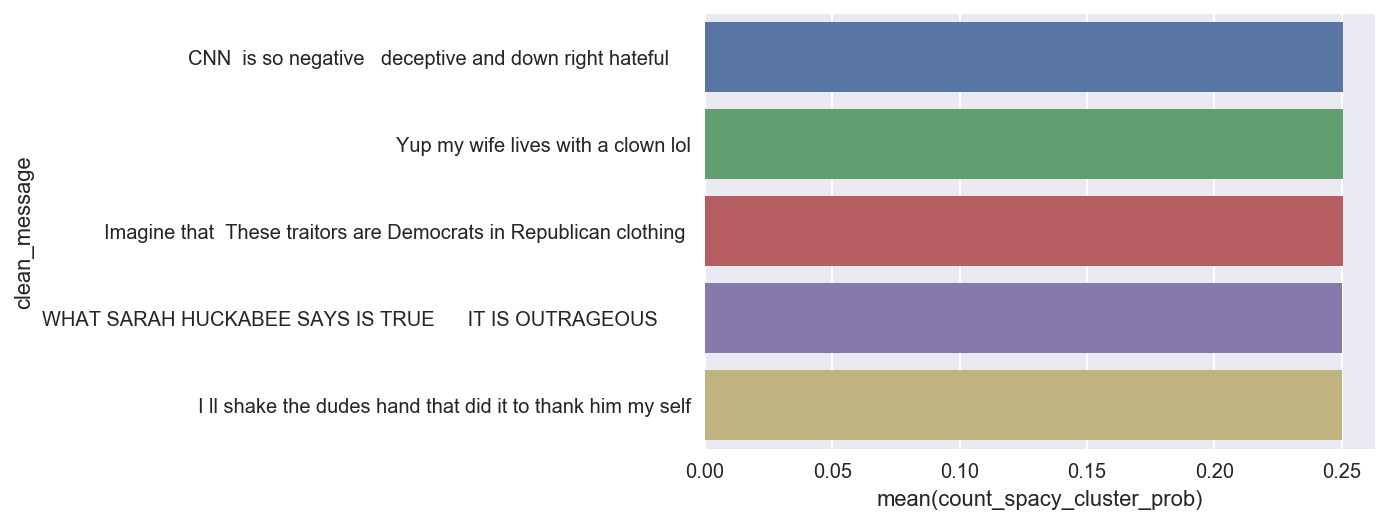

In [69]:
top_10_docs=df[df.count_spacy_cluster==1][['clean_message','count_spacy_cluster_prob']].sort_values(by='count_spacy_cluster_prob',ascending=False).tail(5)
sbs.barplot(x='count_spacy_cluster_prob', y='clean_message', data=top_10_docs);

In [193]:
df[df.count_spacy_cluster==3].loc[2810,'clean_message']

'U got to be kidding   What college  s  is this    Instead of going forward in education we r going stupid'

In [192]:
df[(df.count_spacy_cluster==3) & (df.count_spacy_cluster_prob<0.7)][['clean_message','count_spacy_cluster_prob']].sort_values(by='count_spacy_cluster_prob',ascending=False).head(100)

,clean_message,count_spacy_cluster_prob
830,and hurt the game NUMBER go RG,0.699992
302,It is the end game of all progressive liberals...,0.699987
11657,NUMBER years of silence then NUMBER days ...,0.699621
1926,Yayy Let the black players the owners pay...,0.699303
242,Let s remove the garbage this pos left,0.699003
11222,Obama gave pallets of money to Iran the large...,0.698536
2793,Let s just kick their asses take all of NUMBER...,0.698493
3099,Just turn off the games College games are far...,0.698493
2810,U got to be kidding What college s is this...,0.698338
5768,What There is nothing different about knowi...,0.698097


In [78]:
df[['clean_message','count_spacy_cluster_prob']].to_csv('df_clusters.csv',sep=";",index=False)

### Using NMF


* This is just to show that we try the NMF approuch but we decide to go for LDA for delivery instead

In [79]:
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(dtm_tfidf)
nmf   = nmf_model.fit(dtm_tfidf)
nmf_W = nmf_model.transform(dtm_tfidf)
nmf_H = nmf_model.components_

In [80]:
text=df.clean_message[20]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=count_vectorizer)

Need more parents like this mom👍
She needs to be ticked just like everyone else
Good  we need to know what they have found 
Doesn’t seem like NUMBER  years  So sickening  🌹
They should go back   rebuild Haiti  It s been NUMBER  years   the Haitian economy needs more than tourism to rebuild  it s needs their people back 


In [81]:
text=df.clean_message[1010]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=count_vectorizer)

They love him  the art of the deal  is in his element  Bravo  Mr  PRESIDENT 
My president from Louisiana  Go TRUMP 
Good for you President Trump 
Way to go President Trump  
Way to go President Trump  


In [82]:
text=df.clean_message[2020]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=count_vectorizer)

If true good I m glad        just hope he was tortured   suffered great pain
She needs to be ticked just like everyone else
Good  we need to know what they have found 
Doesn’t seem like NUMBER  years  So sickening  🌹
They should go back   rebuild Haiti  It s been NUMBER  years   the Haitian economy needs more than tourism to rebuild  it s needs their people back 


In [83]:
text=df.clean_message[12050]
print(text)
get_similars(X=X['clean_message'],text=text,model=nmf_W,vectorizer=count_vectorizer)

When is it going to end ssap I hope before he destroys what s left of america
Good fox does not need you
Good Lord  she needs a psych eval     
Rep  Gaetz sent a letter to FBI director NUMBER  NUMBER   NUMBER  months ago   where is the response    this NUMBER   NUMBER   NUMBER   
Hindsight is always NUMBER   NUMBER  as one of my good friends says  
    Dad used to say   He should have thought of that      Ayup 


In [172]:
display_topics(nmf_H, nmf_W, count_vectorizer.get_feature_names(),X['clean_message'],10, 10)

Topic 0:
god bless god bless thank family thank god bless president bless america america bless family
Pagpalain ni Bathala  God Bless
Wisconsin here   God Bless 
God Bless you angel😇🎄🎁🎅
God bless her and them
Ina Stevens Tennessee God bless
This is heroism God bless you
ALWAYSCLOVED THE COWBOYS  GOD BLESS YOU THANK YOU 
GOD BLESS the annonamous Dononer  Thank YOU  
Thank you sir May God bless you 
God bless you ad THANK YOU
Topic 1:
number need people good like time great man country year
If you guys think it was a good accord then you can give the UN  NUMBER  billion dollars of your money  America was the only country that had to reduce their carbon footprint   Europe   China and India had NUMBER  years before they had to   Are you people just stupid   or what 
She needs to be ticked just like everyone else
Good  we need to know what they have found 
Doesn’t seem like NUMBER  years  So sickening  🌹
 NUMBER   NUMBER  people   and only NUMBER  RESTROOMS   Not believing 
They should go 